In [1]:
# Imports and stable code

# Standard library imports
import time
import math
import copy
import os
os.environ["JULIA_NUM_THREADS"] = "1"
from julia.api import Julia
julia = Julia(sysimage="sysimage.so")
from julia import Main
Main.include("model.jl")

import shutil
from tempfile import NamedTemporaryFile
import multiprocessing
from collections import deque
import re
import sqlite3

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize, basinhopping, differential_evolution, OptimizeResult
from scipy.stats import qmc
from joblib import Parallel, delayed


In [2]:
# Infrastructure functions

#ASA Optimizer

def vfsa_accprob(curr_cost, new_cost, temp_acc):
    exponent = np.clip((new_cost - curr_cost) / temp_acc, -500, 500)
    return 1 / (1 + np.exp(exponent))

def vfsa_gen_step(dim, log_lb, log_ub, temp_gen, rng=None):
    if rng is None: 
        rng = np.random.default_rng()

    uni = rng.random(dim)
    base = 1 + 1 / (temp_gen + 1e-10)  # Small value added to avoid division by zero
    exponent = 2 * uni - 1
    rnd = np.sign(uni - 0.5) * temp_gen * (base**np.abs(exponent) - 1)
    return (log_ub - log_lb) * rnd

def vfsa_gen_params(curr_params, dim, log_lb, log_ub, temp_gen, rng=None):
    if rng is None: 
        rng = np.random.default_rng()

    log_params = np.log10(curr_params)
    flag1 = True

    while flag1:
        # Generate a log step
        log_step = vfsa_gen_step(dim, log_lb, log_ub, temp_gen, rng)
        new_log_params = log_params + log_step

        # Check if all new parameters are within bounds
        if np.all(new_log_params >= log_lb) and np.all(new_log_params <= log_ub):
            # If within bounds, convert back to linear scale and return
            par = 10 ** new_log_params
            flag1 = False
        else:
            # If any parameter is out of bounds, handle each one individually
            for i in range(dim):
                if new_log_params[i] < log_lb[i] or new_log_params[i] > log_ub[i]:
                    flag2 = True
                    while flag2:
                        # Generate a new step for the out-of-bounds parameter
                        log_step = vfsa_gen_step(dim, log_lb, log_ub, temp_gen, rng)
                        new_log_params[i] = log_params[i] + log_step[i]

                        # Check if it's now within bounds
                        if log_lb[i] <= new_log_params[i] <= log_ub[i]:
                            flag2 = False

            # Once all parameters are adjusted, convert to linear scale and exit loop
            par = 10 ** new_log_params
            flag1 = False

    return par
        
def vfsa_generinitpoint(dim, log_lb, log_ub, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    
    # Ensure that bounds are valid (finite numbers)
    if not (np.all(np.isfinite(log_lb)) and np.all(np.isfinite(log_ub))):
        raise ValueError("Bounds must be finite numbers")
    
    # Ensure bounds have proper order: log_lb should be less than or equal to log_ub
    if np.any(log_lb > log_ub):
        raise ValueError("Lower bounds must be less than or equal to upper bounds")
    
    flag = True
    while flag:
        # Generate random uniform numbers for each dimension
        uni = rng.random(dim)
        
        # Calculate log_initpoints within the bounds
        log_initpoints = log_lb + (log_ub - log_lb) * uni
        
        # Check if the new points are within the bounds (they should be)
        if np.all(log_initpoints >= log_lb) and np.all(log_initpoints <= log_ub):
            flag = False
    
    # Return the initial points, exponentiated back from log scale to original scale
    return 10 ** log_initpoints

def vfsa_reannealing(best_cost, best_params, curr_cost, dim, x0, tmax, tscat, data, c, temp_gen, temp0_gen, objective_function):
    log_orig_best_params = np.log10(best_params)
    log_par_delta = log_orig_best_params + 0.01 * log_orig_best_params
    par_delta = 10 ** log_par_delta
    
    cost_delta = np.array([
        objective_function(par_delta if i == j else best_params)
        for j in range(dim)
    ])
    
    par_diff = np.clip(par_delta - best_params, 1e-10, None)  # Avoid division by zero
    s = np.abs((cost_delta - best_cost) / par_diff) * (best_params / best_cost)
    smax = np.max(s)
    
    temp_gen = np.clip(temp_gen * (smax / np.clip(s, 1e-10, None)), 1e-10, None)
    
    k_gen = (-1/c * np.log(np.clip(temp_gen / temp0_gen, 1e-10, None))) ** dim
    k_gen = np.clip(k_gen, 0, None)  # Ensure non-negative values
    
    temp0_acc = curr_cost
    temp_acc = best_cost
    k_acc = (-1/c * np.log(np.clip(temp_acc / temp0_acc, 1e-10, None))) ** dim
    
    return temp_gen, k_gen, temp0_acc, temp_acc, k_acc

def vfsa_temp(temp_gen0, c, k_gen, dim, min_temp=1e-10):
    exponent = -c * np.power(k_gen, 1/dim)
    temp = temp_gen0 * np.exp(exponent)
    return np.clip(temp, min_temp, None)

def simulated_annealing(objective_function, initial_solution, lower_bounds, upper_bounds, 
                        initial_temperature, cooling_rate, max_iterations, neighborhood_function, 
                        log_lb, log_ub, temp_gen, 
                        M=10, eps=0.0, min_temp=1e-10, verbose=False):
    
    current_solution = initial_solution
    current_cost = objective_function(current_solution)
    best_solution = current_solution
    best_cost = current_cost
    temperature = initial_temperature

    reanneal_cost_vec = [best_cost]
    diff = deque(maxlen=M)
    best_diff = deque(maxlen=M)
    count_acc_points = 0

    for iteration in range(max_iterations):
        # Generate a new solution in the neighborhood
        new_solution = neighborhood_function(current_solution, len(current_solution), log_lb, log_ub, temp_gen)
        new_cost = objective_function(new_solution)
        delta_cost = new_cost - current_cost
        
        # Acceptance probability
        if delta_cost < 0 or np.random.rand() < np.exp(-delta_cost / temperature):
            current_solution = new_solution
            current_cost = new_cost
            count_acc_points += 1
            
            # Update the best solution found
            if current_cost < best_cost:
                best_solution = current_solution
                best_cost = current_cost

            # Reannealing: Store the best cost at this point
            reanneal_cost_vec.append(best_cost)
            if len(reanneal_cost_vec) > 1:
                diff.append(abs(reanneal_cost_vec[-1] - reanneal_cost_vec[-2]))
                best_diff.append(abs(reanneal_cost_vec[-1] - best_cost))

                # Termination condition based on the last M accepted costs
                if len(diff) == M and all(d <= eps for d in diff) and all(bd <= eps for bd in best_diff):
                    print('ASA converged, terminating at', iteration)
                    break
        
        # Decrease the temperature with a check for minimum temperature
        temperature = max(min_temp, temperature * cooling_rate)
        
        # Progress print statements
        if verbose and iteration % (max_iterations // 10) == 0:
            print(f"Iteration {iteration}: Current cost = {current_cost}, Best cost = {best_cost}")
            print(f"Current solution: {current_solution}")
        
    return best_solution, best_cost

def ASA(objective_function, x0, bounds, maxiter=100, initial_temp=1.0, cooling_rate=0.95, 
        neighborhood_function=vfsa_gen_params, init_function=vfsa_generinitpoint, 
        **kwargs):
    
    dim = len(x0)
    lower_bounds, upper_bounds = np.array(bounds).T
    log_lb, log_ub = np.log10(lower_bounds), np.log10(upper_bounds)
    log_bounds = list(zip(log_lb, log_ub))
    
    # Generate the initial solution
    initial_solution = init_function(dim, log_lb, log_ub)
    
    # Run ASA optimization
    best_solution, best_cost = simulated_annealing(
        objective_function, initial_solution, lower_bounds, upper_bounds,
        initial_temp, cooling_rate, maxiter, neighborhood_function,
        log_lb, log_ub, initial_temp, verbose=True,
        **kwargs
    )
    print('ASA best cost:', best_cost)
    print(best_solution)

    # After simulated annealing, refine the solution with a local optimizer (e.g., L-BFGS-B)
    minimizer_kwargs = {
        'method': 'L-BFGS-B',
        'bounds': bounds,
        'options': {
            'disp': True,
            'maxiter': 250,
        }
    }

    local_result = minimize(
        objective_function,
        x0=best_solution,
        **minimizer_kwargs
    )
    
    final_solution = local_result.x
    final_cost = local_result.fun
    nfev = local_result.nfev
    success = local_result.success

    return OptimizeResult(x=final_solution, fun=final_cost, nfev=nfev, success=success)

class TimeManager:
    def __init__(self):
        self.start_time = time.time()

    def check_timeout(self, timeout: int) -> bool:
        return (time.time() - self.start_time) > timeout

    def reset_start_time(self):
        self.start_time = time.time()

    def get_elapsed_time(self) -> float:
        return time.time() - self.start_time

def unique_colors(ids):
    num_colors = len(ids)
    colors = sns.color_palette("husl", num_colors)
    return dict(zip(ids, colors))

class NoOpMinimizer:
    def __call__(self, x):
        return x

def format_fit_params(fit_parameters):
    if isinstance(fit_parameters, list) and len(fit_parameters) > 1:
        fit_params_str = " ".join(fit_parameters)
    else:
        fit_params_str = fit_parameters[0] if isinstance(fit_parameters, list) else fit_parameters
    
    # Define the replacements
    replacements = {
        r"\bd_E\b": "dₑ",  # d_E -> d subscript E
        r"\bdelta_E\b": "δₑ",  # delta_E -> δ subscript E
        r"\bK_delta_E\b": "K₍δₑ₎",  # K_delta_E -> K subscript δ subscript E
        r"\btau\b": "τ",  # tau -> τ
        r"\bxi\b": "ξ",  # xi -> ξ
        r"\bbeta\b": "β",  # beta -> β
    }

    # Apply the replacements using regex
    for pattern, replacement in replacements.items():
        fit_params_str = re.sub(pattern, replacement, fit_params_str)

    return fit_params_str

def plot(results, subplot_config, group=True, title=None, save=True):
    
    t_span = [0, 10]
    x_ticks = np.arange(t_span[0], t_span[-1] + 1, 1)
    n_subplots = len(subplot_config)
    

    # Determine the number of rows and columns based on the number of subplots
    if n_subplots <= 3:
        n_rows, n_cols = 1, n_subplots
    else:
        n_rows, n_cols = int(np.ceil(np.sqrt(n_subplots))), int(np.ceil(n_subplots / np.sqrt(n_subplots)))

    if group:
        fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 5), squeeze=False)
        axs_flat = axs.flatten()
    
    base_font_size = 14

    title_font_size = base_font_size * 1.4
    label_font_size = base_font_size * 1.2
    tick_font_size = base_font_size * 0.9
    text_font_size = base_font_size * 1.0

    fit_params = {
        103: {'slope': -0.2107, 'intercept': 5.9919, 'start': 2, 'end': 6},
        107: {'slope': -0.3989, 'intercept': 7.3109, 'start': 3, 'end': 6},
        110: {'slope': -0.4535, 'intercept': 6.3292, 'start': 2, 'end': 5},
        111: {'slope': -0.1783, 'intercept': 5.8516, 'start': 2, 'end': 7},
        204: {'slope': -0.9055, 'intercept': 6.3424, 'start': 2, 'end': 4},
        207: {'slope': -0.492, 'intercept': 7.045, 'start': 2, 'end': 4},
        301: {'slope': -0.4196, 'intercept': 8.3419, 'start': 2, 'end': 5},
        302: {'slope': -0.6903, 'intercept': 8.5783, 'start': 2, 'end': 5},
        307: {'slope': -0.5197, 'intercept': 7.9866, 'start': 2, 'end': 5},
        308: {'slope': -0.2045, 'intercept': 6.1577, 'start': 2, 'end': 6},
        311: {'slope': -2.4543, 'intercept': 10.1, 'start': 2, 'end': 3},
        312: {'slope': -0.8099, 'intercept': 9.8591, 'start': 4, 'end': 6},
    }

    impute_params = {
        101: {'imputed': 1, 'val': 6667},
        110: {'imputed': [1, 2], 'val': [6667, 171203]},
        111: {'imputed': [1, 2], 'val': [6667, 171203]},
        112: {'imputed': [1, 2], 'val': [6667, 171203]},
        204: {'imputed': 1, 'val': 6667},
        207: {'imputed': 1, 'val': 6667}
    }

    fit_params_set = set()
    for result, patient in results:
        patient_id = patient.id
        # Get only the parameters that were fit
        fit_parameters = [param_name for param_name, param in patient.parameters._parameters.items() if param.method == 'fit']
        fit_params_set.update(fit_parameters)

        if not group:
            if title is None:
                fit_params_str = format_fit_params(fit_parameters) if fit_parameters else ""
            else:
                fit_params_str = format_fit_params(title)
            title_str = f"Patient {patient_id}{': ' + fit_params_str if fit_params_str else ''}"
            fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 5), squeeze=False)
            axs_flat = axs.flatten()
            fig.suptitle(title_str, fontsize=title_font_size)

        # Extract the SSE for 'V' and 'CD8TE'
        v_sse = None
        cd8te_sse = None

        for idx, state in enumerate(patient.states):
            state_label = state['label']
            if state_label == 'V':
                v_sse = patient.sse_statewise[idx]
            elif state_label == 'CD8TE':
                cd8te_sse = patient.sse_statewise[idx]

        for i, config in enumerate(subplot_config):
            ax = axs_flat[i]
            ax.set_title(config['title'], fontsize=title_font_size)

            if config['data_key']:
                if isinstance(patient_id, str) and patient_id=='Population':
                    ids = [103, 107, 110, 111, 112, 204, 207, 302, 307, 308, 311, 312]
                    volunteer_data = patient.df[patient.df['VOLUNTEER'].isin(ids)].copy()
                else:
                    volunteer_data = patient.df[patient.df['VOLUNTEER'].isin([patient_id])].copy()
                if config['data_scale'] is not None:
                    volunteer_data[config['data_key']] *= config['data_scale']
                
                ax.plot(volunteer_data['DAY'], np.log10(np.maximum(volunteer_data[config['data_key']], 1.0)),
                        marker='o', color=patient.color, linestyle='None', alpha=1.0, zorder=15)

                if not group and config['title'] == 'Virus' and patient_id in fit_params:
                    fit_param = fit_params[patient_id]
                    start, end = fit_param['start'], fit_param['end']
                    slope, intercept = fit_param['slope'], fit_param['intercept']

                    fitting_days = np.arange(start, end + 1)
                    fitting_data = slope * fitting_days + intercept
                    ax.plot(fitting_days, fitting_data, 'r--', zorder=16)

                    if patient_id in impute_params:
                        impute_data = impute_params[patient_id]
                        impute_days = np.array(impute_data['imputed'])
                        impute_vals = np.array(impute_data['val'])

                        ax.plot(impute_days, np.log10(np.maximum(impute_vals, 1)), marker='o', markersize=4, color='white', 
                                markeredgecolor='white', linestyle='None', alpha=1.0, zorder=25)

            if config['sol_key'] is not None and patient.sol:
                sol_t = patient.sol.t
                sol_y_raw = patient.sol.y[config['sol_key']]
                sol_y = np.log10(np.where(sol_y_raw < 1, 1, sol_y_raw))
                ax.plot(sol_t, sol_y, color=patient.color, alpha=0.5)

            if config['ylims']:
                ax.set_ylim(config['ylims'])

            ax.set_xticks(x_ticks)
            ax.set_xlim([t_span[0] - 0.1, t_span[-1] + 0.1])
            ax.set_xlabel('time (d)', fontsize=label_font_size)
            ax.set_ylabel(f'log10 ({config["data_key"]})', fontsize=label_font_size)
            ax.tick_params(axis='both', which='major', labelsize=tick_font_size)

            if not group:
                # Add the SSE to the plot for the relevant state
                #if config['title'] == 'Virus' and v_sse is not None:
                    #ax.text(0.95, 0.05, f'SSE: {v_sse:.4f}', transform=ax.transAxes, 
                            #verticalalignment='bottom', horizontalalignment='right', 
                            #fontsize=text_font_size, color='black')
                if config['title'] == 'CD8 T Effectors' and cd8te_sse is not None:
                    sse=v_sse+cd8te_sse
                    ax.text(0.95, 0.05, f'SSE: {sse:.4f}', transform=ax.transAxes, 
                            verticalalignment='bottom', horizontalalignment='right', 
                            fontsize=text_font_size, color='black')

        for j in range(i + 1, len(axs_flat)):
            axs_flat[j].set_visible(False)

        if not group:
            plt.tight_layout()
            save_dir = os.path.join('plots', f'Patient_{patient_id}')
            os.makedirs(save_dir, exist_ok=True)
            save_path = os.path.join(save_dir, f'{fit_params_str}.png')
            if save: plt.savefig(save_path, bbox_inches='tight')
            plt.show()

    if group:
        fit_params_str = "_".join(sorted(fit_params_set))
        title_str = f"All Patients - Parameters {fit_params_str}"
        fig.suptitle(title_str, fontsize=title_font_size)
        
        plt.tight_layout()
        save_dir = os.path.join('plots', 'Grouped')
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f'{fit_params_str}.png')
        if save: plt.savefig(save_path, bbox_inches='tight')
        plt.show()


In [3]:
# Curent development area 
class Parameter:
    def __init__(self, name, val=None, l_lim=None, u_lim=None, method='fixed', space='log10'):
        self.name = name
        self.space = space
        self.l_lim = self._transform_space(l_lim)
        self.u_lim = self._transform_space(u_lim)
        self.val = val
        self.method = method

    def _transform_space(self, bound):
        if self.space == 'log10':
            return np.log10(bound)
        elif self.space == 'normal':
            return bound

    def _inverse_transform_space(self, value):
        if self.space == 'log10':
            return 10 ** value
        elif self.space == 'normal':
            return value

    def __repr__(self):
        return f"{self.val:.2e}"

    def sweep(self, num_points=100):
        values = np.linspace(self.l_lim, self.u_lim, num=num_points)
        if self.space == 'log10':
            values = 10 ** values  # Inverse transform back to natural space
        return [self._convert_to_type(val) for val in values]

class Parameters:
    def __init__(self, **kwargs):
        self._parameters = kwargs

    def __getattr__(self, item):
        if item in self._parameters:
            return self._parameters[item]
        raise AttributeError(f"'Parameters' object has no attribute '{item}'")

    def __setattr__(self, key, value):
        if key == '_parameters':
            super().__setattr__(key, value)
        else:
            self._parameters[key] = value

    def __getstate__(self):
        return self._parameters

    def __setstate__(self, state):
        self._parameters = state

    def items(self):
        return self._parameters.items()

    def __repr__(self):
        return f"Parameters({', '.join([f'{k}={v}' for k, v in self._parameters.items()])})"

    def load_parameters_from_dataframe(self, df_params, patient_id):
        if patient_id not in df_params['id'].values:
            print(f"ID {patient_id} not found in parameter file.")
            return
        param_values = df_params[df_params['id'] == patient_id].iloc[0]
        for param_name, param_obj in self._parameters.items():
            if param_obj.method == 'file' and param_name in param_values:
                param_val = param_values[param_name]
                if not np.isnan(param_val):
                    param_obj.val = param_val
                else:
                    print(f"Parameter '{param_name}' for ID {patient_id} is missing in the parameter file. Falling back to original values.")

class State:
    def __init__(self, label: str, initial_value: float = 0.0, sse: bool = False, scale: float = 1.0):
        self.label = label
        self.initial_value = initial_value
        self.time_points = np.array([0.0])
        self.sse = sse
        self.scale = scale

    def __repr__(self):
        return f"State(label={self.label}, initial_value={self.initial_value}, sse={self.sse})"

class States:
    def __init__(self, states_config: list):
        self.states = {config['label']: State(**config) for config in states_config}
        self.state_labels = [state.label for state in self.states.values()]

    def __getattr__(self, name: str) -> float:
        return self.states[name].get_latest_value()

    def __repr__(self):
        return f"States({', '.join([f'{k}={v}' for k, v in self.states.items()])}, sse={self.sse})"
    
class Patient:
    def __init__(self, id, color, t_span, df, parameters, states, df_params=None, sol=None, solve_time=np.nan, sse=np.inf, sse_statewise=np.inf):
        self.id = id
        self.color = color
        self.t_span = t_span
        self.df = df
        self.parameters = parameters
        self.states = states
        self.sol = sol
        self.solve_time = solve_time
        self.sse = sse
        self.sse_statewise = sse_statewise

        if df_params is not None:
            self.parameters.load_parameters_from_dataframe(df_params, self.id)
        self.param_names = list(self.parameters._parameters.keys())
        self.results_in_memory = []  # To store results for later DB writes

    def solve(self):
        try:
            self.sol = JuliaSolve((
                self.parameters, self.states, self.t_span
            ))
        except Exception as e:
            self.sol = None
            print(f"Error solving patient {self.id}: {e}")
    
    def compare(self):
  
        slopes = False
        df = self.df
        shedders = [103, 107, 110, 111, 112, 204, 207, 302, 307, 308, 311, 312]
        targets = [self.id]

        for pid in targets:
            #print(f'comparing {pid}')
                if isinstance(pid, str) and pid=='Population':
                    pid_df = df[df['VOLUNTEER'].isin(shedders)]
                    pid_df['VOLUNTEER'] = 'Population'
                elif isinstance(pid, str) and pid=='Murine':
                    murine_ids = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
                    pid_df = df[df['VOLUNTEER'].isin(murine_ids)]
                    pid_df['VOLUNTEER'] = 'Murine'
                else:
                    pid_df = df[df['VOLUNTEER'].isin([pid])]#.copy()
                
                if slopes:
                    all_data_slopes = []
                    all_model_slopes = []
                sse_array = [0] * (len(self.states)+1)
                sse = 0

                for idx, state in enumerate(self.states):
                    state_label = state['label']
                    state_sse = 0
                    
                    if state_label == 'CD8TE' or state_label == 'V':
                        if state_label in pid_df.columns:
                            data_values = pid_df[state_label].values * state.get('scale', 1.0)
                            time_points = pid_df['DAY'].values
                            valid_indices = ~np.isnan(data_values)
                            data_values = data_values[valid_indices]
                            time_points = time_points[valid_indices]

                            weight = 1
                            #if state_label == 'V':
                                #weight = (1 / weight_dict[self.id])

                            if len(data_values) > 0:
                                model_time_points = self.sol.t
                                model_values = self.sol.y[idx]

                                if model_values.shape[0] != len(model_time_points):
                                    model_values = np.transpose(model_values)

                                interpolated_model_values = np.interp(time_points, model_time_points, model_values)

                                # Calculate SSE 
                                for i in range(len(time_points)):

                                    floor = 1.0
                                    data_at_t = data_values[i]
                                    model_at_t = interpolated_model_values[i]
                                    logdata = np.log10(np.maximum(data_at_t, floor))
                                    logmodel = np.log10(np.maximum(model_at_t, floor))
                                    error = (logmodel - logdata) ** 2
                                    state_sse += error
                                    if state.get('sse', True): sse += error * weight

                                    if slopes:
                                        # Collect slopes for all points except the last (forward slope)
                                        if state_label == 'CD8TE' and state.get('sse', True) and i < len(time_points) - 1:
                                            logdata_ti1 = np.log10(np.maximum(data_values[i + 1], floor))
                                            logmodel_ti1 = np.log10(np.maximum(interpolated_model_values[i + 1], floor))

                                            slope_data = logdata_ti1 - logdata
                                            slope_model = logmodel_ti1 - logmodel

                                            if np.isfinite(slope_data) and np.isfinite(slope_model):
                                                all_data_slopes.append(slope_data)
                                                all_model_slopes.append(slope_model)

                            sse_array[idx] = state_sse
                if slopes:
                    # After collecting all slopes, calculate SE3 and apply slope penalties
                    if len(all_data_slopes) > 0 and len(all_model_slopes) > 0:
                        max_slope_data = max(all_data_slopes)
                        min_slope_data = min(all_data_slopes)
                        Vdat = pid_df['V'].values
                        Vdat = Vdat[~np.isnan(Vdat)]
                        SE3 = np.log10(max(Vdat)) / (max_slope_data - min_slope_data)
                        #print('Final Slope weight', SE3, flush=True)

                        for model_slope, data_slope in zip(all_model_slopes, all_data_slopes):
                            slope_penalty = 0.5 * SE3 * (model_slope - data_slope) ** 2
                            sse_array[-1] += slope_penalty

                self.sse = sse
                self.sse_statewise = sse_array
                    
                sse_statewise_db = sse_array
                V_sse_db = sse_statewise_db[3]
                C_sse_db = sse_statewise_db[4]
                sse_db = V_sse_db + C_sse_db

                # Store the parameters and SSEs in memory (defer DB writes)
                all_params = [param.val for param in self.parameters._parameters.values()]
                self.results_in_memory.append((all_params, [V_sse_db, C_sse_db, sse_db], str(pid)))

        return self.sse, self.sse_statewise
    
    def objective_function(self, x):
        for i, name in enumerate(self.param_names):
            if self.parameters._parameters[name].space == 'log10':
                self.parameters._parameters[name].val = 10**x[i]
            else:
                self.parameters._parameters[name].val = x[i]

        self.solve()
        self.compare()

        return self.sse
    
    def write_results_to_db(self, path):
        conn = sqlite3.connect(path)
        cursor = conn.cursor()
        cursor.executemany('''
            INSERT INTO evaluations (
                E0, T0, I10, beta, k, p, c, delta, xi, a, d_E, delta_E, K_delta_E,
                V_sse, C_sse, sse, PID
            ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
        ''', [tuple(p) + tuple(e) + (pid,) for p, e, pid in self.results_in_memory])
        conn.commit()
        conn.close()
        self.results_in_memory = [] # Flush the results from memory
        print(f'Results saved to {path}.',flush=True)

    def optimize_parameters(self, method='halton', iter=1000, verbose=False, path='output', local_iter=1000, local_method='L-BFGS-B', seed=34):
        fit_parameters = {name: param for name, param in self.parameters._parameters.items() if param.method == 'fit'}

        if not fit_parameters:
            print("No parameters to optimize")
            self.solve()
            self.compare()
            return (None, self)

        
        #initial_values = [np.log10(param.val) if param.space == 'log10' else param.val for param in fit_parameters.values()]
        initial_values = []
        for param in fit_parameters.values():
            sampled_value = np.random.uniform(param.l_lim, param.u_lim)
            if param.space == 'log10':
                initial_values.append(10**sampled_value)
            else:
                initial_values.append(sampled_value)

        bounds = [(param.l_lim, param.u_lim) for param in fit_parameters.values()]
        self.param_names = list(fit_parameters.keys())  # Save param_names as instance variable
        number_fit = len(self.param_names)

        minimizer_kwargs = {
            'method': local_method,
            'bounds': bounds,
            'options': {
                    'xatol': 1e-6,
                    'fatol': 1e-6,
                    'disp': verbose,
                    'maxiter': local_iter,
            }}

        if method == 'differential_evolution':

            print(f'{self.id} Differential Evolution with {iter} generations.',flush=True)
            # Single instance of DE in serial
            result = differential_evolution(
                self.objective_function,
                bounds=bounds,
                strategy='best1bin',
                maxiter=iter,
                popsize=100,
                mutation=(0.2, 0.9),
                recombination=0.9,
                seed=seed,
                disp=verbose,
                polish=False,
                init='halton',
                workers=1, 
                vectorized=False
            )
        
        elif method == 'ASA':
            result = ASA(
                self.objective_function,
                x0=initial_values, 
                bounds=bounds,
                maxiter=iter,
                initial_temp=1.0,
                cooling_rate=0.95,
                neighborhood_function=vfsa_gen_params,
                init_function=vfsa_generinitpoint,
                M=15,  # Number of accepted costs for convergence
                eps=1e-6
            )
        
        elif method == 'basin_hopping':
            class BoundedStep:
                def __init__(self, fit_parameters, stepsize=0.5, normal_sampling=False):
                    self.fit_parameters = fit_parameters
                    self.stepsize = stepsize
                    self.normal_sampling = normal_sampling
                    self.precomputed = {}

                    for i, (param_name, param) in enumerate(self.fit_parameters.items()):
                        lower, upper = param.l_lim, param.u_lim
                        if param.space == 'log10':
                            lower, upper = np.log10(lower), np.log10(upper)

                        self.precomputed[i] = {
                            'lower': lower,
                            'upper': upper,
                            'range': upper - lower,
                            'is_log': param.space == 'log10'
                        }

                def __call__(self, x):
                    rng = np.random.default_rng(seed)

                    for i in range(len(x)):
                        bounds = self.precomputed[i]
                        lower, upper, range_, is_log = bounds['lower'], bounds['upper'], bounds['range'], bounds['is_log']

                        if self.normal_sampling:
                            # Sample from a normal distribution, transform to [0, 1], then to desired range
                            step = rng.normal(0, self.stepsize)  # Step in standard normal space
                            step = np.clip(step, -3, 3)  # Clip to a range that mostly falls within [-3, 3] std devs
                            normalized_step = (step + 3) / 6  # Map from [-3, 3] to [0, 1]
                        else:
                            # Uniform sampling in [0, 1]
                            normalized_step = rng.uniform()

                        # Transform normalized step to the target range
                        step = (normalized_step - 0.5) * self.stepsize * range_

                        # Apply step and clip to the transformed bounds
                        x[i] = np.clip(x[i] + step, lower, upper)

                        # Transform back to the original space if necessary
                        if is_log:
                            x[i] = 10 ** x[i]

                    return x

            print(f'{self.id} Basin Hopping with n = {iter}',flush=True)
            result = basinhopping(
                self.objective_function,  
                x0=initial_values,
                niter=iter,
                T=0.01,
                stepsize=1.0,
                minimizer_kwargs=minimizer_kwargs,
                take_step=BoundedStep(fit_parameters, stepsize=1.0),
                interval=1,
                disp=verbose,
                niter_success=2,
                seed=seed,
                target_accept_rate=0.5,
                stepwise_factor=0.8,
            )
        
        elif method == 'halton':
            print(f'{self.id} Halton with n = {iter}', flush=True)
            # Halton sampling-based optimization
            sampler = qmc.Halton(d=number_fit)
            n_samples = iter  # Number of samples for Halton sequence
            step_size = n_samples // 20  # 5% of n_samples

            # Generate Halton samples in [0, 1] and scale them to the parameter bounds
            halton_samples = sampler.random(n_samples)
            scaled_samples = qmc.scale(halton_samples, [b[0] for b in bounds], [b[1] for b in bounds])
            best_sample = None
            best_sse = np.inf
            progress_count = 0

            for i, sample in enumerate(scaled_samples):
                sse = self.objective_function(sample)
                if sse < best_sse:
                    best_sse = sse
                    best_sample = sample

                # Print progress every 5% 
                if (i + 1) % step_size == 0:
                    progress_count += 5
                    print(f"Progress: {progress_count}% of samples evaluated ({i+1}/{n_samples})")

            # Assign the best-found parameters back to the model
            result = OptimizeResult()
            result.x = best_sample
            result.fun = best_sse
        
        else: # Local solver fallback 
            fallback_minimizer_kwargs = {
            'method': local_method,
            'bounds': bounds,
            'options': {
                    'xatol': 1e-6,
                    'fatol': 1e-6,
                    'disp': True,
                    'maxiter': iter,
            }}
            print(f'{self.id} {local_method} with n = {iter}',flush=True)
            result = minimize(
                self.objective_function, 
                x0=initial_values,
                **fallback_minimizer_kwargs
            )

        # Write results to database
        db_path = f'sql/{path}.db'
        os.makedirs('sql', exist_ok=True)
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS evaluations (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                E0 REAL, T0 REAL, I10 REAL, beta REAL, k REAL,
                p REAL, c REAL, delta REAL, xi REAL, a REAL,
                d_E REAL, delta_E REAL, K_delta_E REAL,
                V_sse REAL, C_sse REAL, sse REAL, PID REAL
            )
        ''')
        conn.commit()
        conn.close()
        self.write_results_to_db(path=db_path)

        # Final update of parameters
        for i, name in enumerate(self.param_names):
            if self.parameters._parameters[name].space == 'log10':
                self.parameters._parameters[name].val = 10**result.x[i]
            else:
                self.parameters._parameters[name].val = result.x[i]
            print(f'Parameter {name}: {self.parameters._parameters[name].val}')

        # Solve and compare with the best-found parameters
        self.solve()
        self.results_in_memory = []
        Main.GC.gc()

        return (result, self)
    
    def __repr__(self):
        return f"Patient({self.id}, sse={self.sse}, parameters={self.parameters})"

class Patients:
    def __init__(self, ids, df, t_span, parameters, states, parameter_file=None):
        self.color_dict = unique_colors(ids)
        t_fill = np.linspace(t_span[0], t_span[-1], 250)
        t_int = np.arange(t_span[0], t_span[-1] + 1)
        self.t_span = np.unique(np.concatenate([t_span, t_fill, t_int]))
        self.df = df
        self.parameters = parameters
        self.states = states
        # Load the parameters from the Excel file once
        if parameter_file:
            self.df_params = self.load_excel_parameters(parameter_file)
        else:
            print('No parameters loaded: No file specified. Add parameter_file= to Patients initialization call.')
            self.df_params = None

        self.patients = {
            id: Patient(
                id,
                self.color_dict[id],
                self.t_span,
                self.df,
                copy.deepcopy(self.parameters),
                copy.deepcopy(self.states),
                self.df_params
            ) for id in ids
        }

        self.parameters.patients = self.patients

    def load_excel_parameters(self, parameter_file):
        parameter_file = os.path.abspath(parameter_file)
        df_params = None

        try:
            with NamedTemporaryFile(delete=False, suffix='.xlsx') as temp_file:
                temp_path = temp_file.name
                shutil.copyfile(parameter_file, temp_path)
            df_params = pd.read_excel(temp_path)

        except Exception as e:
            print(f"An error occurred: {e}")
            return None
        finally:
            if os.path.exists(temp_path):
                os.remove(temp_path)

        return df_params

    def solve(self):
        for patient in self.patients.values():
            patient.solve()
            
    def compare(self, ids=None):
        if ids is None:
            ids = self.patients.keys()
        for patient_id in ids:
            self.patients[patient_id].compare()
    
    def optimize_parameters(self, opt_target, method, iter, path, verbose=False, local_iter=1000, local_method='L-BFGS-B'):
        results = []
        for patient in self.patients.values():
            if patient.id == opt_target:
                result = patient.optimize_parameters(method=method, iter=iter, verbose=verbose, path=path, local_iter=local_iter, local_method=local_method)
                results.append(result)
        return results
    
    def sweep_parameter(self, param_name, num_points=10, percentage_range=None):
        param_to_sweep = self.parameters._parameters.get(param_name)
        if param_to_sweep is None:
            raise ValueError(f"Parameter {param_name} not found.")
        
        print(f'Sweeping parameter: {param_name}')
        
        if percentage_range is not None:
            initial_value = param_to_sweep.val
            lower_bound = initial_value * (1 - percentage_range / 100)
            upper_bound = initial_value * (1 + percentage_range / 100)
            if param_to_sweep.space == 'log10':
                l_lim_transformed = np.log10(lower_bound)
                u_lim_transformed = np.log10(upper_bound)
                sweep_values = np.linspace(l_lim_transformed, u_lim_transformed, num=num_points)
                sweep_values = 10 ** sweep_values
            elif param_to_sweep.space == 'normal':
                sweep_values = np.linspace(lower_bound, upper_bound, num=num_points)
            else:
                raise ValueError(f"Unsupported space type: {param_to_sweep.space}")
        else:
            sweep_values = param_to_sweep.sweep(num_points)

        sweep_ids = [f'S{i}' for i in range(num_points)]

        def solve_for_value(i, value, patient):
            patient.parameters._parameters[param_name].val = value
            patient.solve()
            patient.compare()
            return patient

        num_cores = multiprocessing.cpu_count() - 1

        # Parallel execution across patients
        sweep_patients = []
        for patient in self.patients.values():
            results = Parallel(n_jobs=num_cores)(
                delayed(solve_for_value)(i, value, patient)
                for i, value in enumerate(sweep_values)
            )
            sweep_patients.extend(results)

        return sweep_patients, sweep_values

    def __getitem__(self, id):
        patient = self.patients.get(id, None)
        if patient is not None:
            return repr(patient)
        return None

    def __repr__(self):
        return '\n'.join(repr(patient) for patient in self.patients.values())

class JuliaODESolution:
    def __init__(self, t, y):
        self.t = np.array(t)  # Time points
        self.y = np.array(y)  # Transposed solution values (states over time)

    def __repr__(self):
        return f"JuliaODESolution(t={self.t}, y={self.y})"

def solve_with_julia(t_span, y0, params):
    t_span = (float(np.float64(t_span[0])), float(np.float64(t_span[-1])))
    y0 = [float(np.float64(val)) for val in y0]

    # Convert params from dict to a list (vector) in the correct order and ensure they are Float32
    params_julia = [
        float(np.float64(params["beta"])),
        float(np.float64(params["k"])),
        float(np.float64(params["delta"])),
        float(np.float64(params["delta_E"])),
        float(np.float64(params["K_delta_E"])),
        float(np.float64(params["p"])),
        float(np.float64(params["c"])),
        float(np.float64(params["xi"])),
        #float(np.float64(params["tau"])),
        float(np.float64(params["a"])),
        float(np.float64(params["d_E"]))
    ]
    # Call the Julia function
    t_values, y_values = Main.tmap_LCTModel(t_span, y0, params_julia)

    # Convert Julia arrays to NumPy arrays
    t_values = np.array(t_values, dtype=np.float64)
    y_values = np.array(y_values, dtype=np.float64)

    # Return the solution
    return JuliaODESolution(t=t_values, y=y_values)

def JuliaSolve(task):
    def inner_solve(param_set, states_config, t_span):
        states_config_copy = states_config.copy()
        # Prepare parameters and initial conditions for Julia
        params = {
            "beta": param_set.beta.val,
            "k": param_set.k.val,
            "delta": param_set.delta.val,
            "delta_E": param_set.delta_E.val,
            "K_delta_E": param_set.K_delta_E.val,
            "p": param_set.p.val,
            "c": param_set.c.val,
            "xi": param_set.xi.val,
            #"tau": param_set.tau.val,
            "a": param_set.a.val,
            "d_E": param_set.d_E.val  # Ensure this value is correct
        }

        # Debugging: Print updated parameters just before solving
        #print(f"Updated parameters being passed to Julia: {params}", flush=True)

        states_instance = States(states_config_copy)
        y0 = np.array([states_instance.states[config['label']].initial_value for config in states_config])
        y0[0] = param_set.T0.val
        y0[1] = param_set.I10.val

        # Solve using Julia
        sol = solve_with_julia(t_span, y0, params)
        sol.y[4] += param_set.E0.val  # Add the background E0
        return sol

    sol = inner_solve(*task)
    return sol


In [ ]:
# Myers Setup
shedders = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
targets = ['Population']
ids = targets + shedders
subplot_configuration = [
    #{'title': 'Target Cells', 'data_key': None, '2nd_data_key': None, 'sol_key': 0, '2nd_sol_key': None, 'data_scale': None, 'ylims': [1, 5E8]},
    #{'title': 'Eclipse Cells', 'data_key': None, 'sol_key': 1, 'data_scale': None, 'ylims': [1, 5E8]},
    #{'title': 'Infected Cells', 'data_key': None, '2nd_data_key': None, 'sol_key': 2, '2nd_sol_key': None, 'data_scale': None, 'ylims': [1, 5E8]},
    {'title': 'Virus', 'data_key': 'V', '2nd_data_key': None, 'sol_key': 3, '2nd_sol_key': None, 'data_scale': None, 'ylims': [0,8]},
    {'title': 'CD8 T Effectors', 'data_key': 'CD8TE', '2nd_data_key': 'CD8TE', 'sol_key': 4, '2nd_sol_key': None, 'data_scale': None, 'ylims': [4.5,8]}, #[3E4,3E7]
    #{'title': 'CD8T Lung Cells', 'data_key': None, '2nd_data_key': None, 'sol_key': 5, '2nd_sol_key': None, 'data_scale': None, 'ylims': None},
]

n_Z = 13
t_span = (0.0, 10.0)
# Import data
df = pd.read_excel("../Data/Murine Data.xlsx", sheet_name='Dynamics')
df_Myers = df[['VOLUNTEER', 'DAY', 'V', 'IFNG', 'CD8TE']]

states = [
    {'label': 'T', 'initial_value': 1E7, 'sse': False},
    {'label': 'I1', 'initial_value': 75.0, 'sse': False},
    {'label': 'I2', 'initial_value': 0.0, 'sse': False},
    {'label': 'V', 'initial_value': 0.0, 'sse': True},
    {'label': 'CD8T_E', 'initial_value': 0.0, 'sse': False},
    {'label': 'CD8T_Mem', 'initial_value': 0.0, 'sse': False},
    {'label': 'CD8T_Tot', 'initial_value': 0.0, 'sse': True}
]

for i in range(1, n_Z + 1):
    states.append({'label': f'Z{i}', 'initial_value': 0.0, 'sse': False})


parameters = Parameters(
    E0=Parameter(name='E0', val=3.43E5, l_lim=2E4, u_lim=1.2E6, method='file', space='log10'),
    T0=Parameter(name='T0', val=4E7, l_lim=1E7, u_lim=4.001E7, method='fixed', space='log10'),
    I10=Parameter(name='I10', val=75, l_lim=1, u_lim=1E3, method='fixed', space='log10'), 
    beta=Parameter(name='beta', val=1.0888E-4, l_lim=5E-7, u_lim=5E-2, method='fit', space='log10'), 
    k=Parameter(name='k', val=4.0, l_lim=1.0, u_lim=10.0, method='fixed', space='log10'), 
    p=Parameter(name='p', val=0.02978, l_lim=1, u_lim=10, method='fit', space='normal'), 
    c=Parameter(name='c', val=13.934, l_lim=10.0, u_lim=1E3, method='fit', space='log10'), 
    delta=Parameter(name='delta', val=0.96, l_lim=0.4, u_lim=2.5, method='fit', space='normal'),
    xi=Parameter(name='xi', val=0.1198, l_lim=1E-2, u_lim=10.0, method='fit', space='normal'), 
    a=Parameter(name='a', val=2.5, l_lim=1.0, u_lim=15, method='fit', space='normal'), 
    d_E=Parameter(name='d_E', val=0.75, l_lim=0.5, u_lim=2.5, method='fit', space='normal'),
    delta_E=Parameter(name='delta_E', val=8.939, l_lim=1E-1, u_lim=10, method='fit', space='normal'),
    K_delta_E=Parameter(name='K_delta_E', val=1.3E4, l_lim=1E1, u_lim=1E5, method='fit', space='log10'),
)

patients = Patients(ids=ids, df=df_Rahil, t_span=t_span, parameters=parameters, states=states, parameter_file='LCT.xlsx')
short = [111]
for target in shedders:
    results = patients.optimize_parameters(method='differential_evolution', opt_target=target, 
                                        iter=100, verbose=True, path='Viral_CD38')

    plot(results, subplot_configuration, title=None, group=False, save=False)

In [12]:
# Rahil Setup
shedders = [103, 107, 110, 111, 112, 204, 207, 302, 307, 308, 311, 312]
targets = ['Population']
ids = targets + shedders
subplot_configuration = [
    #{'title': 'Target Cells', 'data_key': None, '2nd_data_key': None, 'sol_key': 0, '2nd_sol_key': None, 'data_scale': None, 'ylims': [1, 5E8]},
    #{'title': 'Eclipse Cells', 'data_key': None, 'sol_key': 1, 'data_scale': None, 'ylims': [1, 5E8]},
    #{'title': 'Infected Cells', 'data_key': None, '2nd_data_key': None, 'sol_key': 2, '2nd_sol_key': None, 'data_scale': None, 'ylims': [1, 5E8]},
    {'title': 'Virus', 'data_key': 'V', '2nd_data_key': None, 'sol_key': 3, '2nd_sol_key': None, 'data_scale': None, 'ylims': [0,8]},
    {'title': 'CD8 T Effectors', 'data_key': 'CD8TE', '2nd_data_key': 'CD8TE', 'sol_key': 4, '2nd_sol_key': None, 'data_scale': None, 'ylims': [4.5,8]}, #[3E4,3E7]
    #{'title': 'CD8T Lung Cells', 'data_key': None, '2nd_data_key': None, 'sol_key': 5, '2nd_sol_key': None, 'data_scale': None, 'ylims': None},
]

n_Z = 13
t_span = (0.0, 10.0)
# Import data
df = pd.read_excel("../Data/Rahil_2020/Table8_Healed.xlsx", sheet_name='Main', usecols=list(range(0, 143)))
df = df[['VOLUNTEER', 'DAY', 'V', 'IFNG', 'CD8TE']]
df_Rahil = df.loc[df['DAY'] < 9]

In [5]:
# LCT Model, Viral Parameters (p + 8 others)
states = [
    {'label': 'T', 'initial_value': 4E7, 'sse': False},
    {'label': 'I1', 'initial_value': 75.0, 'sse': False},
    {'label': 'I2', 'initial_value': 0.0, 'sse': False},
    {'label': 'V', 'initial_value': 0.0, 'sse': True},
    {'label': 'CD8TE', 'initial_value': 0.0, 'sse': True},
    {'label': 'CD8TLung', 'initial_value': 0.0, 'sse': False},
]

for i in range(1, n_Z + 1):
    states.append({'label': f'Z{i}', 'initial_value': 0.0, 'sse': False})


In [ ]:

parameters = Parameters(
    E0=Parameter(name='E0', val=3.43E5, l_lim=2E4, u_lim=1.2E6, method='file', space='log10'),
    T0=Parameter(name='T0', val=4E7, l_lim=1E7, u_lim=4.001E7, method='fixed', space='log10'),
    I10=Parameter(name='I10', val=75, l_lim=1, u_lim=1E3, method='fixed', space='log10'), 
    beta=Parameter(name='beta', val=1.0888E-4, l_lim=5E-7, u_lim=5E-2, method='fit', space='log10'), 
    k=Parameter(name='k', val=4.0, l_lim=1.0, u_lim=10.0, method='fixed', space='log10'), 
    p=Parameter(name='p', val=0.02978, l_lim=1, u_lim=10, method='fit', space='normal'), 
    c=Parameter(name='c', val=13.934, l_lim=10.0, u_lim=1E3, method='fit', space='log10'), 
    delta=Parameter(name='delta', val=0.96, l_lim=0.4, u_lim=2.5, method='fit', space='normal'),
    xi=Parameter(name='xi', val=0.1198, l_lim=1E-2, u_lim=10.0, method='fit', space='normal'), 
    a=Parameter(name='a', val=2.5, l_lim=1.0, u_lim=15, method='fit', space='normal'), 
    d_E=Parameter(name='d_E', val=0.75, l_lim=0.5, u_lim=2.5, method='fit', space='normal'),
    delta_E=Parameter(name='delta_E', val=8.939, l_lim=1E-1, u_lim=10, method='fit', space='normal'),
    K_delta_E=Parameter(name='K_delta_E', val=1.3E4, l_lim=1E1, u_lim=1E5, method='fit', space='log10'),
)

patients = Patients(ids=ids, df=df_Rahil, t_span=t_span, parameters=parameters, states=states, parameter_file='LCT.xlsx')
short = [111]
for target in shedders:
    results = patients.optimize_parameters(method='differential_evolution', opt_target=target, 
                                        iter=100, verbose=True, path='Viral_CD38')

    plot(results, subplot_configuration, title=None, group=False, save=False)

Population Differential Evolution with 100 generations.
differential_evolution step 1: f(x)= 274.5301390135778
differential_evolution step 2: f(x)= 270.53748513259956
differential_evolution step 3: f(x)= 261.45149970466855
differential_evolution step 4: f(x)= 261.45149970466855
differential_evolution step 5: f(x)= 259.6140155002033
differential_evolution step 6: f(x)= 257.8409112931869
differential_evolution step 7: f(x)= 256.0757603323579
differential_evolution step 8: f(x)= 256.0757603323579
differential_evolution step 9: f(x)= 255.34540500981714
differential_evolution step 10: f(x)= 255.20712431800905
differential_evolution step 11: f(x)= 255.10431282212195
differential_evolution step 12: f(x)= 255.10431282212195
differential_evolution step 13: f(x)= 255.08849561452388
differential_evolution step 14: f(x)= 255.0344545568658
differential_evolution step 15: f(x)= 254.1826350252689
differential_evolution step 16: f(x)= 253.7384854082965
differential_evolution step 17: f(x)= 253.2495691

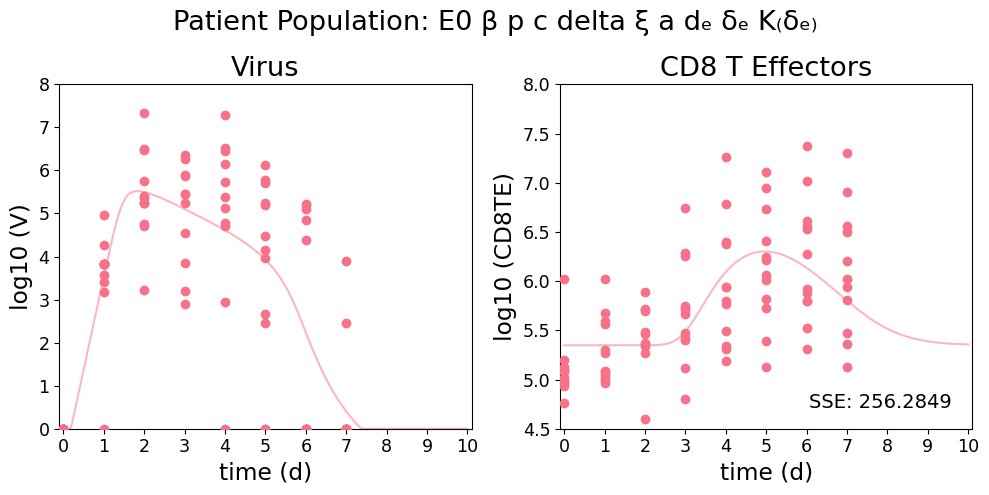

In [6]:
parameters = Parameters( 
    E0=Parameter(name='E0', val=3.43E5, l_lim=2E4, u_lim=1.2E6, method='fit', space='log10'), 
    T0=Parameter(name='T0', val=4E7, l_lim=1E7, u_lim=4.001E7, method='fixed', space='log10'),
    I10=Parameter(name='I10', val=75, l_lim=1, u_lim=1E3, method='fixed', space='log10'), 
    beta=Parameter(name='beta', val=1.0888E-4, l_lim=5E-7, u_lim=5E-2, method='fit', space='log10'), 
    k=Parameter(name='k', val=4.0, l_lim=1.0, u_lim=10.0, method='fixed', space='log10'), 
    p=Parameter(name='p', val=0.02978, l_lim=1, u_lim=10, method='fit', space='normal'), 
    c=Parameter(name='c', val=13.934, l_lim=10.0, u_lim=1E3, method='fit', space='log10'), 
    delta=Parameter(name='delta', val=0.96, l_lim=0.4, u_lim=2.5, method='fit', space='normal'),
    xi=Parameter(name='xi', val=0.1198, l_lim=1E-2, u_lim=10.0, method='fit', space='normal'), 
    a=Parameter(name='a', val=2.5, l_lim=1.0, u_lim=15, method='fit', space='normal'), 
    d_E=Parameter(name='d_E', val=0.75, l_lim=0.5, u_lim=2.5, method='fit', space='normal'),
    delta_E=Parameter(name='delta_E', val=8.939, l_lim=1E-1, u_lim=10, method='fit', space='normal'),
    K_delta_E=Parameter(name='K_delta_E', val=1.3E4, l_lim=1E1, u_lim=1E5, method='fit', space='log10'),
)

patients = Patients(ids=ids, df=df_Rahil, t_span=t_span, parameters=parameters, states=states, parameter_file='LCT.xlsx')
for target in targets:
    results = patients.optimize_parameters(method='differential_evolution', opt_target=target, 
                                        iter=100, verbose=True, path='Viral_CD38')

    plot(results, subplot_configuration, title=None, group=False, save=False)

112 Differential Evolution with 100 generations.
differential_evolution step 1: f(x)= 2.350598569085705
differential_evolution step 2: f(x)= 1.5999473093624903
differential_evolution step 3: f(x)= 1.55563391932176
differential_evolution step 4: f(x)= 1.55563391932176
differential_evolution step 5: f(x)= 1.4693712035313038
differential_evolution step 6: f(x)= 1.4076598337402557
differential_evolution step 7: f(x)= 1.4076598337402557
differential_evolution step 8: f(x)= 1.2824245363338678
differential_evolution step 9: f(x)= 1.2824245363338678
differential_evolution step 10: f(x)= 1.2281616318332165
differential_evolution step 11: f(x)= 1.195975457613146
differential_evolution step 12: f(x)= 1.195975457613146
differential_evolution step 13: f(x)= 1.195975457613146
differential_evolution step 14: f(x)= 1.1955027328309813
differential_evolution step 15: f(x)= 1.1787116858916935
differential_evolution step 16: f(x)= 1.1787116858916935
differential_evolution step 17: f(x)= 1.176052796741812


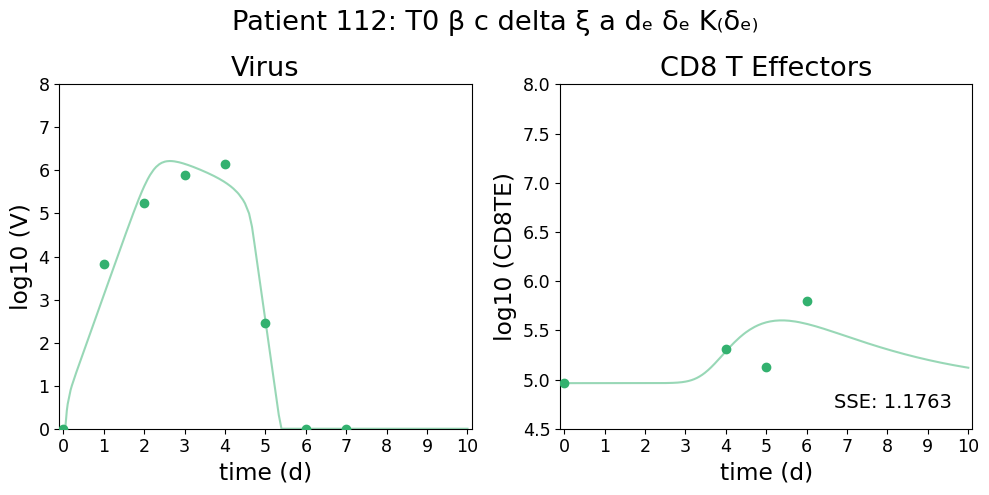

In [11]:
# Does Niave: Fix p to the Population best from [p] fit, re-fit all parameters + T0 to Virus + CD8TE
states = [
    {'label': 'T', 'initial_value': 4E7, 'sse': False},
    {'label': 'I1', 'initial_value': 75.0, 'sse': False},
    {'label': 'I2', 'initial_value': 0.0, 'sse': False},
    {'label': 'V', 'initial_value': 0.0, 'sse': True},
    {'label': 'CD8TE', 'initial_value': 0.0, 'sse': True},
    {'label': 'CD8TLung', 'initial_value': 0.0, 'sse': False},
]

for i in range(1, n_Z + 1):
    states.append({'label': f'Z{i}', 'initial_value': 0.0, 'sse': False})

parameters = Parameters(
    E0=Parameter(name='E0', val=3.43E5, l_lim=2E4, u_lim=1.2E6, method='file', space='log10'), # 1.1E5, 8.9E5 for CD38+Ki67+
    T0=Parameter(name='T0', val=4E7, l_lim=1E7, u_lim=4.001E7, method='fit', space='log10'),
    I10=Parameter(name='I10', val=75, l_lim=1, u_lim=1E3, method='fixed', space='log10'), 
    beta=Parameter(name='beta', val=1.0888E-4, l_lim=5E-7, u_lim=5E-2, method='fit', space='log10'), 
    k=Parameter(name='k', val=4.0, l_lim=1.0, u_lim=10.0, method='fixed', space='log10'), 
    p=Parameter(name='p', val=4.184819310239195, l_lim=1, u_lim=10, method='fixed', space='normal'), 
    c=Parameter(name='c', val=13.934, l_lim=10.0, u_lim=1E3, method='fit', space='log10'), 
    delta=Parameter(name='delta', val=0.96, l_lim=0.4, u_lim=2.5, method='fit', space='normal'),
    xi=Parameter(name='xi', val=0.1198, l_lim=1E-2, u_lim=10.0, method='fit', space='normal'), 
    a=Parameter(name='a', val=2.5, l_lim=1.0, u_lim=15, method='fit', space='normal'), 
    d_E=Parameter(name='d_E', val=0.75, l_lim=0.5, u_lim=2.5, method='fit', space='normal'),
    delta_E=Parameter(name='delta_E', val=8.939, l_lim=1E-1, u_lim=10, method='fit', space='normal'),
    K_delta_E=Parameter(name='K_delta_E', val=1.3E4, l_lim=1E1, u_lim=1E5, method='fit', space='log10'),
)


patients = Patients(ids=ids, df=df_Rahil, t_span=t_span, parameters=parameters, states=states, parameter_file='LCT.xlsx')

for target in shedders:
    results = patients.optimize_parameters(method='differential_evolution', opt_target=target, 
                                        iter=100, verbose=True, path='T0Naive_CD38')

    plot(results, subplot_configuration, title=None, group=False, save=False)

Population Differential Evolution with 100 generations.
differential_evolution step 1: f(x)= 279.4201541554968
differential_evolution step 2: f(x)= 279.4201541554968
differential_evolution step 3: f(x)= 260.9513723768381
differential_evolution step 4: f(x)= 260.9513723768381
differential_evolution step 5: f(x)= 260.9513723768381
differential_evolution step 6: f(x)= 260.5956494924023
differential_evolution step 7: f(x)= 258.32383372169534
differential_evolution step 8: f(x)= 258.32383372169534
differential_evolution step 9: f(x)= 258.32383372169534
differential_evolution step 10: f(x)= 258.32383372169534
differential_evolution step 11: f(x)= 256.79472423514824
differential_evolution step 12: f(x)= 255.51720563617226
differential_evolution step 13: f(x)= 255.15699837036544
differential_evolution step 14: f(x)= 252.21719587316628
differential_evolution step 15: f(x)= 251.56047682373264
differential_evolution step 16: f(x)= 251.56047682373264
differential_evolution step 17: f(x)= 251.50050

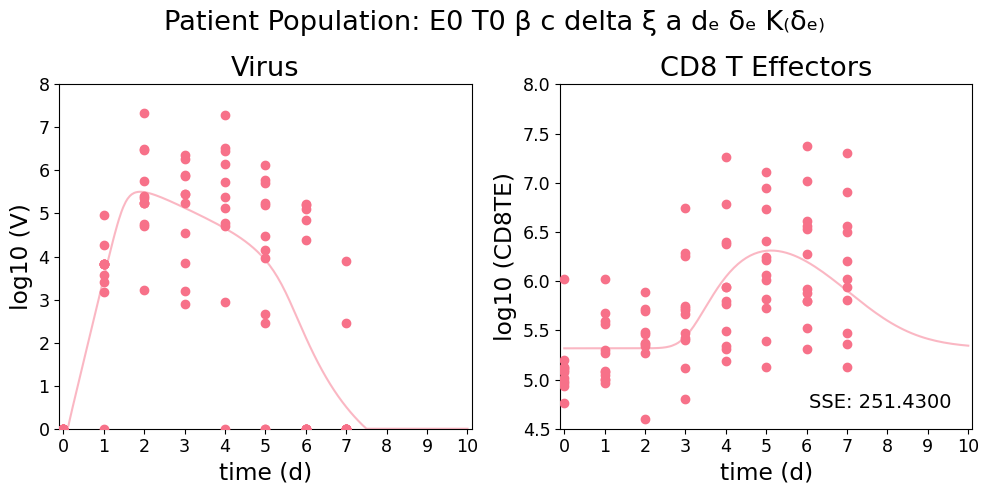

In [8]:
parameters = Parameters(
    E0=Parameter(name='E0', val=3.43E5, l_lim=2E4, u_lim=1.2E6, method='fit', space='log10'), # 1.1E5, 8.9E5 for CD38+Ki67+
    T0=Parameter(name='T0', val=4E7, l_lim=1E7, u_lim=4.001E7, method='fit', space='log10'),
    I10=Parameter(name='I10', val=75, l_lim=1, u_lim=1E3, method='fixed', space='log10'), 
    beta=Parameter(name='beta', val=1.0888E-4, l_lim=5E-7, u_lim=5E-2, method='fit', space='log10'), 
    k=Parameter(name='k', val=4.0, l_lim=1.0, u_lim=10.0, method='fixed', space='log10'), 
    p=Parameter(name='p', val=4.184819310239195, l_lim=1, u_lim=10, method='fixed', space='normal'), 
    c=Parameter(name='c', val=13.934, l_lim=10.0, u_lim=1E3, method='fit', space='log10'), 
    delta=Parameter(name='delta', val=0.96, l_lim=0.4, u_lim=2.5, method='fit', space='normal'),
    xi=Parameter(name='xi', val=0.1198, l_lim=1E-2, u_lim=10.0, method='fit', space='normal'), 
    a=Parameter(name='a', val=2.5, l_lim=1.0, u_lim=15, method='fit', space='normal'), 
    d_E=Parameter(name='d_E', val=0.75, l_lim=0.5, u_lim=2.5, method='fit', space='normal'),
    delta_E=Parameter(name='delta_E', val=8.939, l_lim=1E-1, u_lim=10, method='fit', space='normal'),
    K_delta_E=Parameter(name='K_delta_E', val=1.3E4, l_lim=1E1, u_lim=1E5, method='fit', space='log10'),
)


patients = Patients(ids=ids, df=df_Rahil, t_span=t_span, parameters=parameters, states=states, parameter_file='LCT.xlsx')
for target in targets:
    results = patients.optimize_parameters(method='differential_evolution', opt_target=target, 
                                        iter=100, verbose=True, path='T0Naive_CD38')

    plot(results, subplot_configuration, title=None, group=False, save=False)

103 Differential Evolution with 100 generations.
differential_evolution step 1: f(x)= 5.584003779009583
differential_evolution step 2: f(x)= 4.3454623529324925
differential_evolution step 3: f(x)= 3.074033941465674
differential_evolution step 4: f(x)= 3.074033941465674
differential_evolution step 5: f(x)= 3.074033941465674
differential_evolution step 6: f(x)= 2.5927588663150813
differential_evolution step 7: f(x)= 2.3682779397896354
differential_evolution step 8: f(x)= 2.3682779397896354
differential_evolution step 9: f(x)= 2.233091076914515
differential_evolution step 10: f(x)= 2.233091076914515
differential_evolution step 11: f(x)= 2.233091076914515
differential_evolution step 12: f(x)= 2.157954456605284
differential_evolution step 13: f(x)= 2.157954456605284
differential_evolution step 14: f(x)= 2.1444277651103008
differential_evolution step 15: f(x)= 2.1444277651103008
differential_evolution step 16: f(x)= 2.095151157622557
differential_evolution step 17: f(x)= 2.0592371284598157
d

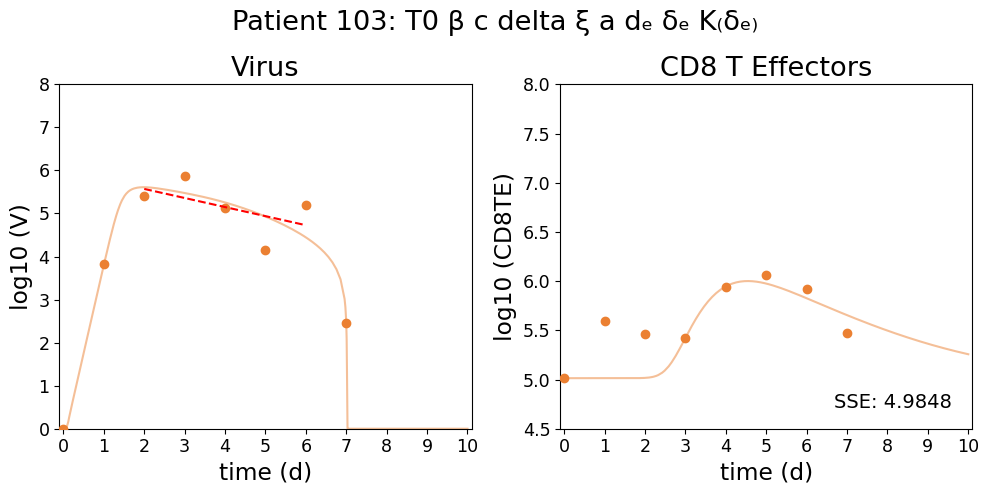

107 Differential Evolution with 100 generations.
differential_evolution step 1: f(x)= 3.3505655705991515
differential_evolution step 2: f(x)= 2.838493804320402
differential_evolution step 3: f(x)= 2.383080740711718
differential_evolution step 4: f(x)= 2.383080740711718
differential_evolution step 5: f(x)= 1.5037676536814149
differential_evolution step 6: f(x)= 1.316259654688101
differential_evolution step 7: f(x)= 1.3145706263066759
differential_evolution step 8: f(x)= 1.2082866256128715
differential_evolution step 9: f(x)= 1.2082866256128715
differential_evolution step 10: f(x)= 1.1606169892801181
differential_evolution step 11: f(x)= 1.0827369874593313
differential_evolution step 12: f(x)= 1.0827369874593313
differential_evolution step 13: f(x)= 1.0637912289945444
differential_evolution step 14: f(x)= 1.01490702143988
differential_evolution step 15: f(x)= 1.0046600278719264
differential_evolution step 16: f(x)= 0.9452629572228521
differential_evolution step 17: f(x)= 0.90782515686924

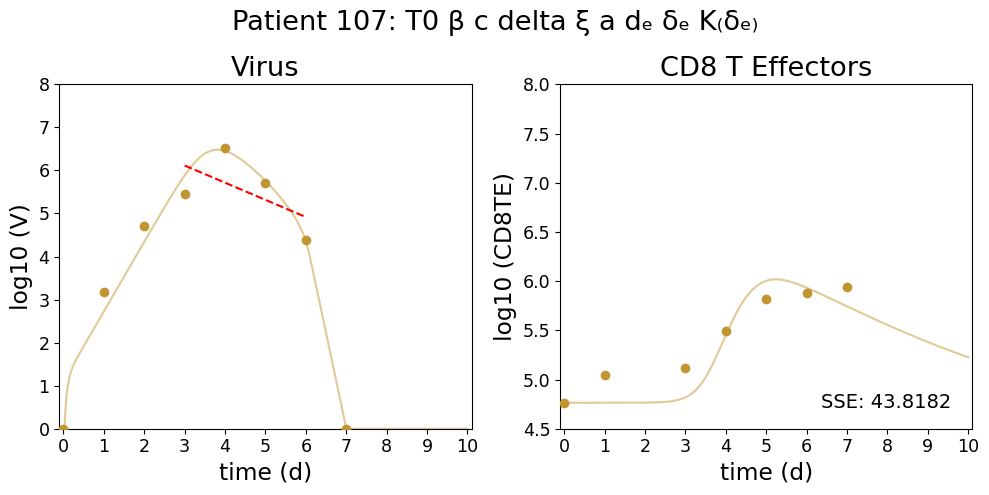

110 Differential Evolution with 100 generations.
differential_evolution step 1: f(x)= 2.6724209912415375
differential_evolution step 2: f(x)= 1.7416376896058368
differential_evolution step 3: f(x)= 0.9567897506097098
differential_evolution step 4: f(x)= 0.9567897506097098
differential_evolution step 5: f(x)= 0.2198216663775746
differential_evolution step 6: f(x)= 0.2198216663775746
differential_evolution step 7: f(x)= 0.2198216663775746
differential_evolution step 8: f(x)= 0.2198216663775746
differential_evolution step 9: f(x)= 0.2198216663775746
differential_evolution step 10: f(x)= 0.19528413346826218
differential_evolution step 11: f(x)= 0.1478133194699599
differential_evolution step 12: f(x)= 0.11489360706864078
differential_evolution step 13: f(x)= 0.11482852715997759
differential_evolution step 14: f(x)= 0.10947780416550888
differential_evolution step 15: f(x)= 0.08940441542076977
differential_evolution step 16: f(x)= 0.08463838425943174
differential_evolution step 17: f(x)= 0.08

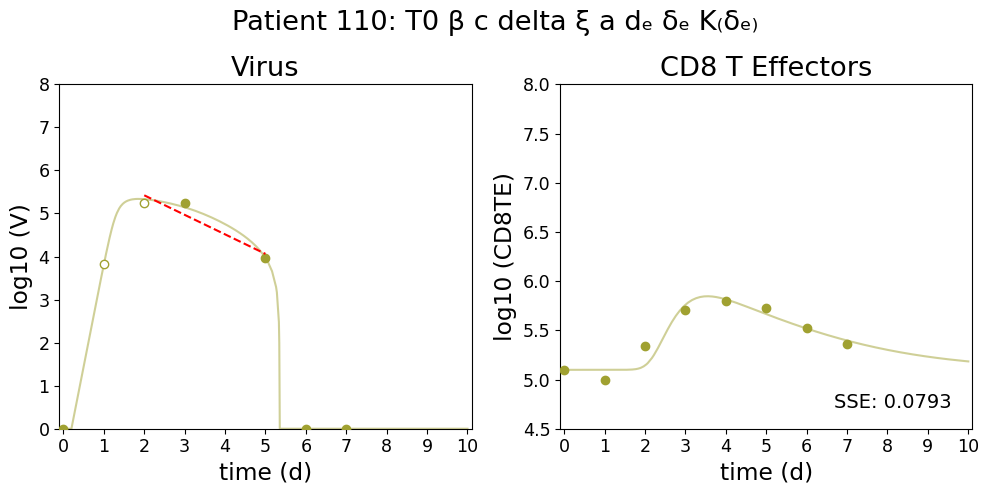

111 Differential Evolution with 100 generations.
differential_evolution step 1: f(x)= 11.395926401930446
differential_evolution step 2: f(x)= 7.869001761759806
differential_evolution step 3: f(x)= 7.521302590379323
differential_evolution step 4: f(x)= 7.521302590379323
differential_evolution step 5: f(x)= 7.521302590379323
differential_evolution step 6: f(x)= 7.521302590379323
differential_evolution step 7: f(x)= 4.1803761243251785
differential_evolution step 8: f(x)= 3.696009633214794
differential_evolution step 9: f(x)= 3.6700473295195724
differential_evolution step 10: f(x)= 3.51793637560922
differential_evolution step 11: f(x)= 2.9362461716853567
differential_evolution step 12: f(x)= 2.6572029062183136
differential_evolution step 13: f(x)= 2.4599507063296278
differential_evolution step 14: f(x)= 2.4599507063296278
differential_evolution step 15: f(x)= 2.4599507063296278
differential_evolution step 16: f(x)= 2.4599507063296278
differential_evolution step 17: f(x)= 2.4599507063296278

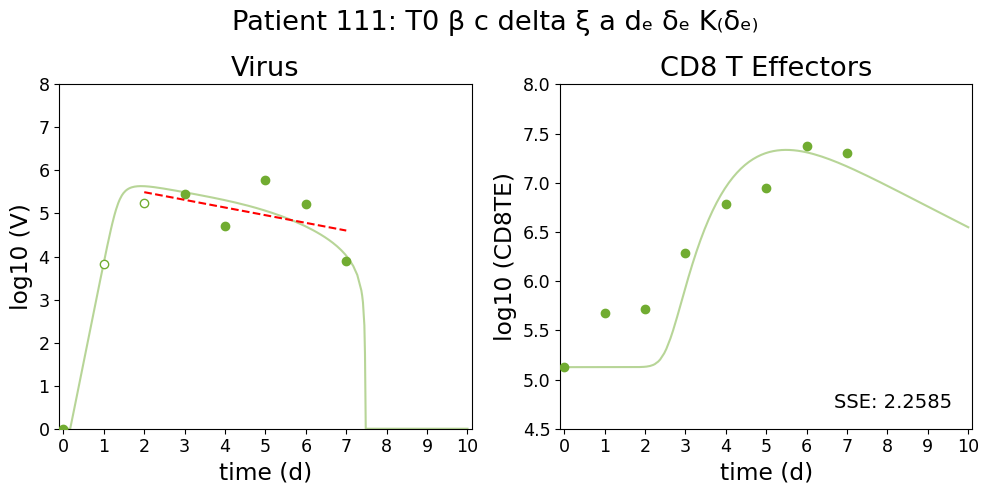

112 Differential Evolution with 100 generations.
differential_evolution step 1: f(x)= 4.9303468860192
differential_evolution step 2: f(x)= 3.404356092732562
differential_evolution step 3: f(x)= 3.2030487259089844
differential_evolution step 4: f(x)= 3.181727168994316
differential_evolution step 5: f(x)= 2.963332108133208
differential_evolution step 6: f(x)= 2.8545625712250056
differential_evolution step 7: f(x)= 2.8031025969073746
differential_evolution step 8: f(x)= 2.7607757474335948
differential_evolution step 9: f(x)= 2.748682354712462
differential_evolution step 10: f(x)= 2.722100985744768
differential_evolution step 11: f(x)= 2.715707534569103
differential_evolution step 12: f(x)= 2.7143809804626904
differential_evolution step 13: f(x)= 2.6965456164160844
differential_evolution step 14: f(x)= 2.6961641260519342
differential_evolution step 15: f(x)= 2.6961641260519342
differential_evolution step 16: f(x)= 2.6961641260519342
differential_evolution step 17: f(x)= 2.6929147805055096


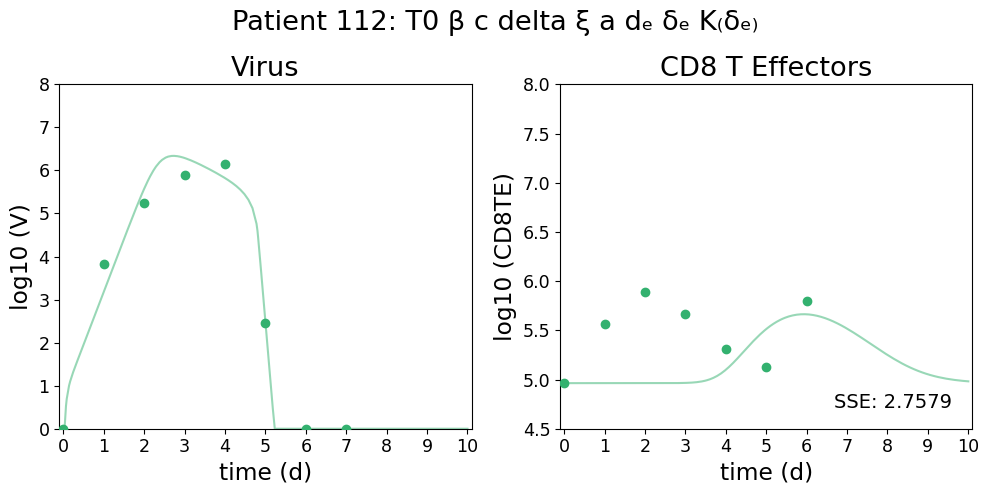

204 Differential Evolution with 100 generations.
differential_evolution step 1: f(x)= 1.3024217407401506
differential_evolution step 2: f(x)= 1.2490027491220494
differential_evolution step 3: f(x)= 1.0904225222192359
differential_evolution step 4: f(x)= 1.0591092566116018
differential_evolution step 5: f(x)= 0.9215163237586572
differential_evolution step 6: f(x)= 0.9215163237586572
differential_evolution step 7: f(x)= 0.9093101183548981
differential_evolution step 8: f(x)= 0.880977850679942
differential_evolution step 9: f(x)= 0.7898827566338524
differential_evolution step 10: f(x)= 0.7276376108321024
differential_evolution step 11: f(x)= 0.7153934245045821
differential_evolution step 12: f(x)= 0.7153934245045821
differential_evolution step 13: f(x)= 0.7083566967128936
differential_evolution step 14: f(x)= 0.7083566967128936
differential_evolution step 15: f(x)= 0.7083566967128936
differential_evolution step 16: f(x)= 0.7083566967128936
differential_evolution step 17: f(x)= 0.708356696

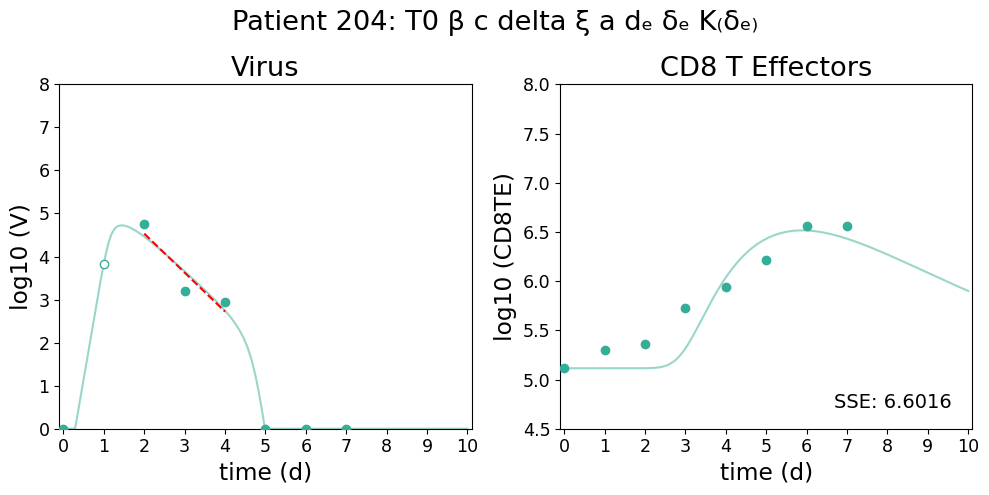

207 Differential Evolution with 100 generations.
differential_evolution step 1: f(x)= 3.919096430354345
differential_evolution step 2: f(x)= 3.919096430354345
differential_evolution step 3: f(x)= 2.4736016821349702
differential_evolution step 4: f(x)= 2.4736016821349702
differential_evolution step 5: f(x)= 2.0927100039876505
differential_evolution step 6: f(x)= 1.9383254178015956
differential_evolution step 7: f(x)= 1.9383254178015956
differential_evolution step 8: f(x)= 1.9383254178015956
differential_evolution step 9: f(x)= 1.9383254178015956
differential_evolution step 10: f(x)= 1.9383254178015956
differential_evolution step 11: f(x)= 1.9233252394381424
differential_evolution step 12: f(x)= 1.9233252394381424
differential_evolution step 13: f(x)= 1.5297010924041126
differential_evolution step 14: f(x)= 1.5297010924041126
differential_evolution step 15: f(x)= 1.4403275728908176
differential_evolution step 16: f(x)= 1.2646291837009922
differential_evolution step 17: f(x)= 1.2200362137

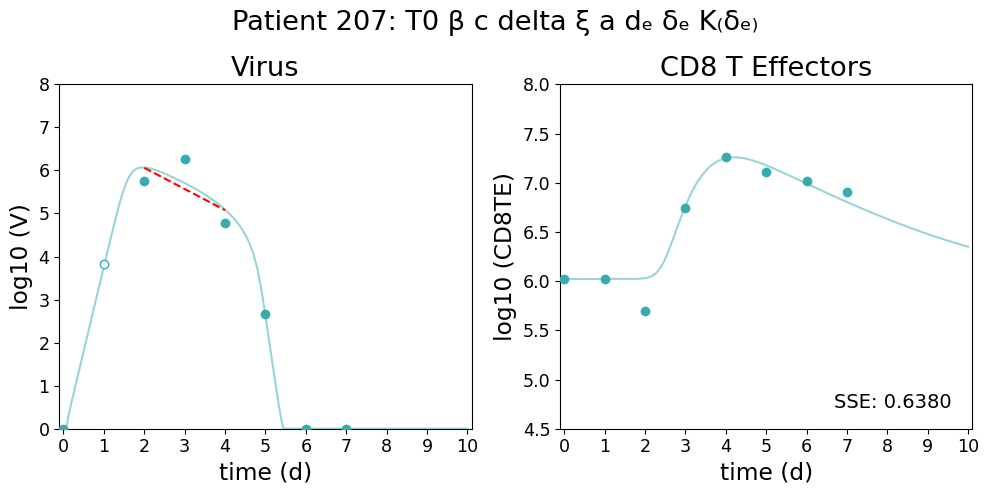

302 Differential Evolution with 100 generations.
differential_evolution step 1: f(x)= 2.35675400971833
differential_evolution step 2: f(x)= 2.35675400971833
differential_evolution step 3: f(x)= 1.6078830376650037
differential_evolution step 4: f(x)= 1.3158627234601536
differential_evolution step 5: f(x)= 1.0281807360913642
differential_evolution step 6: f(x)= 1.0281807360913642
differential_evolution step 7: f(x)= 1.0281807360913642
differential_evolution step 8: f(x)= 0.8770038646957687
differential_evolution step 9: f(x)= 0.8144118156393214
differential_evolution step 10: f(x)= 0.6908389310766844
differential_evolution step 11: f(x)= 0.6428712982604576
differential_evolution step 12: f(x)= 0.6428712982604576
differential_evolution step 13: f(x)= 0.5922458348031132
differential_evolution step 14: f(x)= 0.5067230156704577
differential_evolution step 15: f(x)= 0.5067230156704577
differential_evolution step 16: f(x)= 0.45563453257737985
differential_evolution step 17: f(x)= 0.45563453257

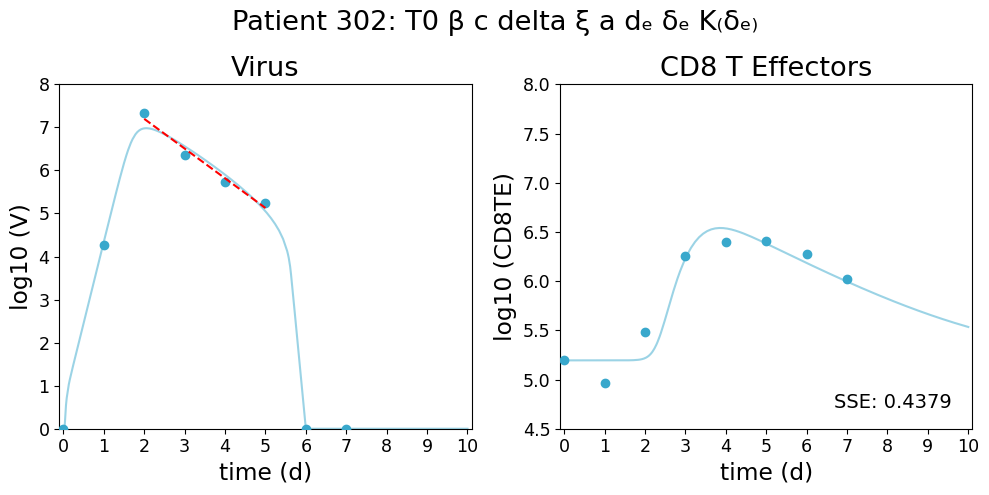

307 Differential Evolution with 100 generations.
differential_evolution step 1: f(x)= 4.349158624258172
differential_evolution step 2: f(x)= 3.103583101489402
differential_evolution step 3: f(x)= 1.705631989327619
differential_evolution step 4: f(x)= 1.5926506071288378
differential_evolution step 5: f(x)= 1.5926506071288378
differential_evolution step 6: f(x)= 1.089552144034225
differential_evolution step 7: f(x)= 1.089552144034225
differential_evolution step 8: f(x)= 0.8667156414586872
differential_evolution step 9: f(x)= 0.8667156414586872
differential_evolution step 10: f(x)= 0.8453969315635077
differential_evolution step 11: f(x)= 0.8453969315635077
differential_evolution step 12: f(x)= 0.8426967337033177
differential_evolution step 13: f(x)= 0.7595175711756804
differential_evolution step 14: f(x)= 0.7400212057669232
differential_evolution step 15: f(x)= 0.7397409313044733
differential_evolution step 16: f(x)= 0.7355289997120548
differential_evolution step 17: f(x)= 0.7350446149541

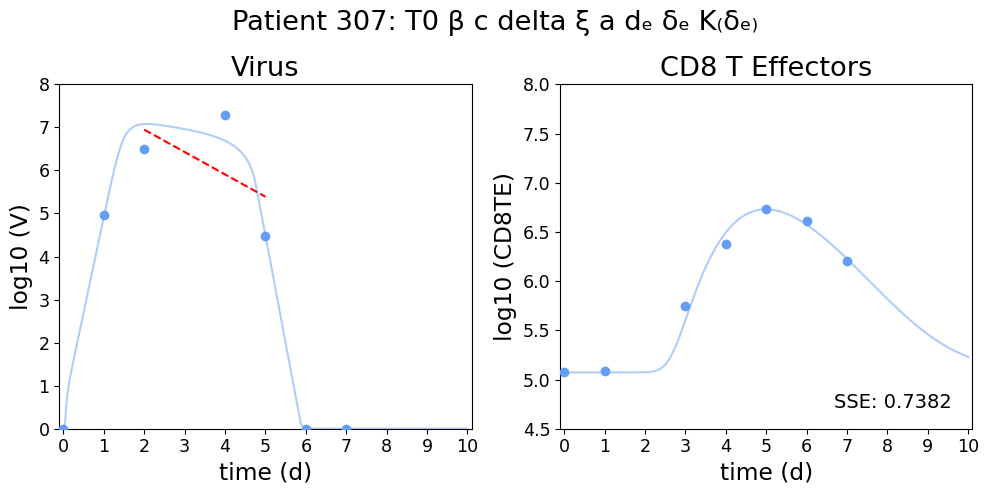

308 Differential Evolution with 100 generations.
differential_evolution step 1: f(x)= 3.9683755961224474
differential_evolution step 2: f(x)= 3.42444093904367
differential_evolution step 3: f(x)= 2.517563426160158
differential_evolution step 4: f(x)= 2.504716802830909
differential_evolution step 5: f(x)= 2.5017324398944445
differential_evolution step 6: f(x)= 2.486027740301028
differential_evolution step 7: f(x)= 2.447851200290022
differential_evolution step 8: f(x)= 2.4413091272815266
differential_evolution step 9: f(x)= 2.4235993118796104
differential_evolution step 10: f(x)= 2.3958739947690173
differential_evolution step 11: f(x)= 2.3958739947690173
differential_evolution step 12: f(x)= 2.377451483419217
differential_evolution step 13: f(x)= 2.377451483419217
differential_evolution step 14: f(x)= 2.377451483419217
differential_evolution step 15: f(x)= 2.3458110731248745
differential_evolution step 16: f(x)= 2.3458110731248745
differential_evolution step 17: f(x)= 2.3458110731248745


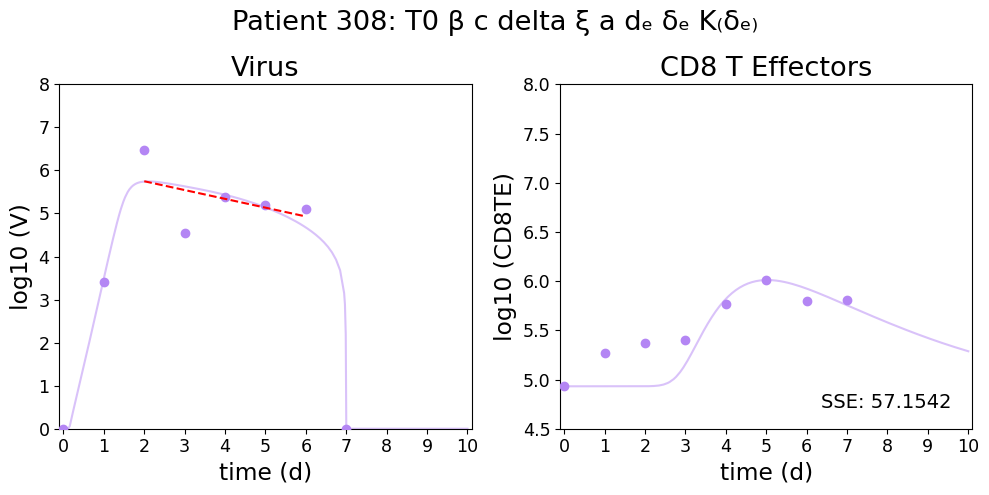

311 Differential Evolution with 100 generations.
differential_evolution step 1: f(x)= 3.5702723461779846
differential_evolution step 2: f(x)= 3.1609619900901125
differential_evolution step 3: f(x)= 2.933456464599313
differential_evolution step 4: f(x)= 2.222598417221784
differential_evolution step 5: f(x)= 1.8951889439351604
differential_evolution step 6: f(x)= 1.8132513585660086
differential_evolution step 7: f(x)= 1.1445978848899223
differential_evolution step 8: f(x)= 1.1445978848899223
differential_evolution step 9: f(x)= 0.9605323396404994
differential_evolution step 10: f(x)= 0.8525046547723789
differential_evolution step 11: f(x)= 0.8525046547723789
differential_evolution step 12: f(x)= 0.8525046547723789
differential_evolution step 13: f(x)= 0.8525046547723789
differential_evolution step 14: f(x)= 0.8435224505332983
differential_evolution step 15: f(x)= 0.8435224505332983
differential_evolution step 16: f(x)= 0.8056157965742492
differential_evolution step 17: f(x)= 0.7708348056

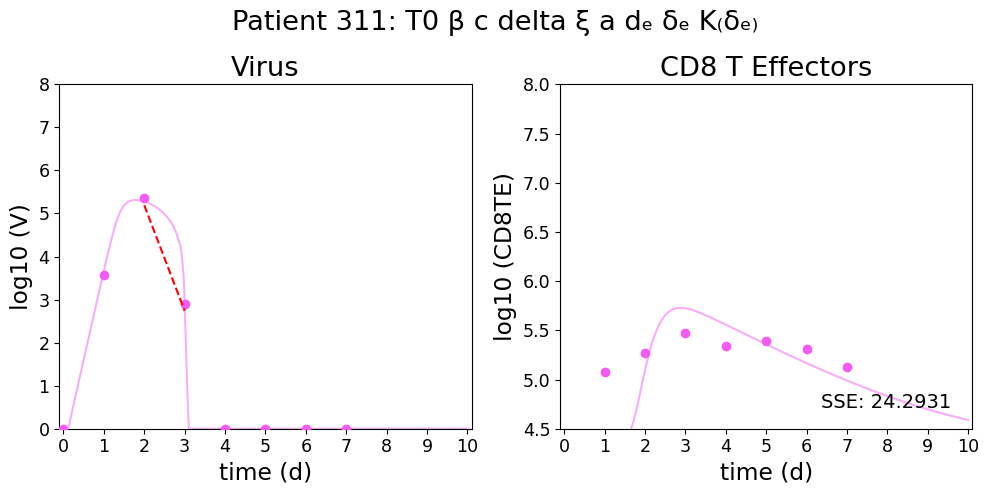

312 Differential Evolution with 100 generations.
differential_evolution step 1: f(x)= 5.436417659094027
differential_evolution step 2: f(x)= 4.826089614202294
differential_evolution step 3: f(x)= 4.20920914564598
differential_evolution step 4: f(x)= 4.1726450010473
differential_evolution step 5: f(x)= 3.501980206838082
differential_evolution step 6: f(x)= 3.501980206838082
differential_evolution step 7: f(x)= 3.2310354580067253
differential_evolution step 8: f(x)= 3.2310354580067253
differential_evolution step 9: f(x)= 3.2178842183326943
differential_evolution step 10: f(x)= 3.1731985128442104
differential_evolution step 11: f(x)= 3.1731985128442104
differential_evolution step 12: f(x)= 3.1676129248797897
differential_evolution step 13: f(x)= 3.1666193135545053
differential_evolution step 14: f(x)= 3.147802675174695
differential_evolution step 15: f(x)= 3.147802675174695
differential_evolution step 16: f(x)= 3.147802675174695
differential_evolution step 17: f(x)= 3.1457573952996905
dif

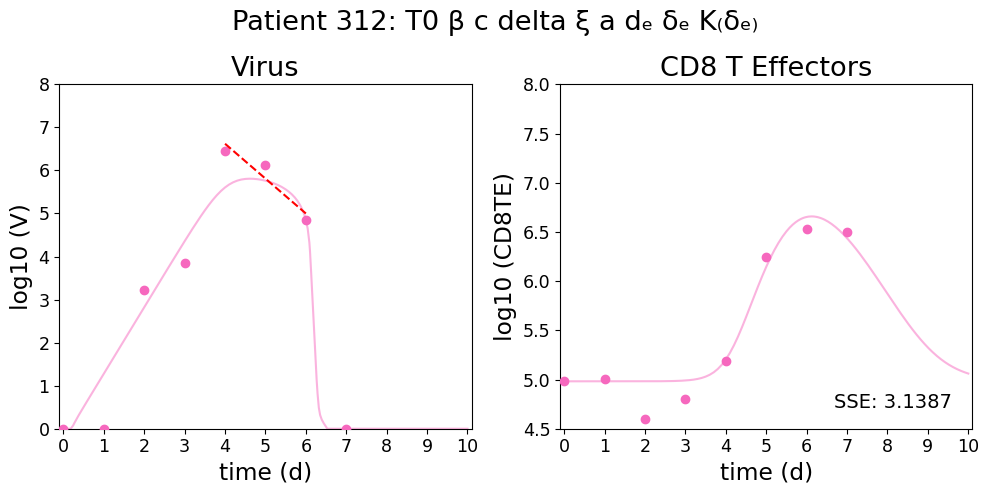

In [9]:
# Does Niave: Fix p to the Individual best from [p] fit, re-fit all parameters + T0 to Virus + CD8TE
states = [
    {'label': 'T', 'initial_value': 4E7, 'sse': False},
    {'label': 'I1', 'initial_value': 75.0, 'sse': False},
    {'label': 'I2', 'initial_value': 0.0, 'sse': False},
    {'label': 'V', 'initial_value': 0.0, 'sse': True},
    {'label': 'CD8TE', 'initial_value': 0.0, 'sse': True},
    {'label': 'CD8TLung', 'initial_value': 0.0, 'sse': False},
]

for i in range(1, n_Z + 1):
    states.append({'label': f'Z{i}', 'initial_value': 0.0, 'sse': False})

parameters = Parameters(
    E0=Parameter(name='E0', val=3.43E5, l_lim=2E4, u_lim=1.2E6, method='file', space='log10'), # 1.1E5, 8.9E5 for CD38+Ki67+
    T0=Parameter(name='T0', val=4E7, l_lim=1E7, u_lim=4.001E7, method='fit', space='log10'),
    I10=Parameter(name='I10', val=75, l_lim=1, u_lim=1E3, method='fixed', space='log10'), 
    beta=Parameter(name='beta', val=1.0888E-4, l_lim=5E-7, u_lim=5E-2, method='fit', space='log10'), 
    k=Parameter(name='k', val=4.0, l_lim=1.0, u_lim=10.0, method='fixed', space='log10'), 
    p=Parameter(name='p', val=4.184819310239195, l_lim=1, u_lim=10, method='file', space='normal'), 
    c=Parameter(name='c', val=13.934, l_lim=10.0, u_lim=1E3, method='fit', space='log10'), 
    delta=Parameter(name='delta', val=0.96, l_lim=0.4, u_lim=2.5, method='fit', space='normal'),
    xi=Parameter(name='xi', val=0.1198, l_lim=1E-2, u_lim=10.0, method='fit', space='normal'), 
    a=Parameter(name='a', val=2.5, l_lim=1.0, u_lim=15, method='fit', space='normal'), 
    d_E=Parameter(name='d_E', val=0.75, l_lim=0.5, u_lim=2.5, method='fit', space='normal'),
    delta_E=Parameter(name='delta_E', val=8.939, l_lim=1E-1, u_lim=10, method='fit', space='normal'),
    K_delta_E=Parameter(name='K_delta_E', val=1.3E4, l_lim=1E1, u_lim=1E5, method='fit', space='log10'),
)

patients = Patients(ids=ids, df=df_Rahil, t_span=t_span, parameters=parameters, states=states, parameter_file='LCT.xlsx')
for target in shedders:
    results = patients.optimize_parameters(method='differential_evolution', opt_target=target, 
                                        iter=100, verbose=True, path='T0IndP_CD38')

    plot(results, subplot_configuration, title=None, group=False, save=False)

Population Differential Evolution with 100 generations.
differential_evolution step 1: f(x)= 279.42015415549685
differential_evolution step 2: f(x)= 279.42015415549685
differential_evolution step 3: f(x)= 260.95137237683815
differential_evolution step 4: f(x)= 260.95137237683815
differential_evolution step 5: f(x)= 260.95137237683815
differential_evolution step 6: f(x)= 260.59564949240234
differential_evolution step 7: f(x)= 258.3238337216954
differential_evolution step 8: f(x)= 258.3238337216954
differential_evolution step 9: f(x)= 258.3238337216954
differential_evolution step 10: f(x)= 258.3238337216954
differential_evolution step 11: f(x)= 256.79472423514824
differential_evolution step 12: f(x)= 255.5172056361723
differential_evolution step 13: f(x)= 255.15699837036553
differential_evolution step 14: f(x)= 252.2171958731662
differential_evolution step 15: f(x)= 251.56047682373267
differential_evolution step 16: f(x)= 251.56047682373267
differential_evolution step 17: f(x)= 251.50050

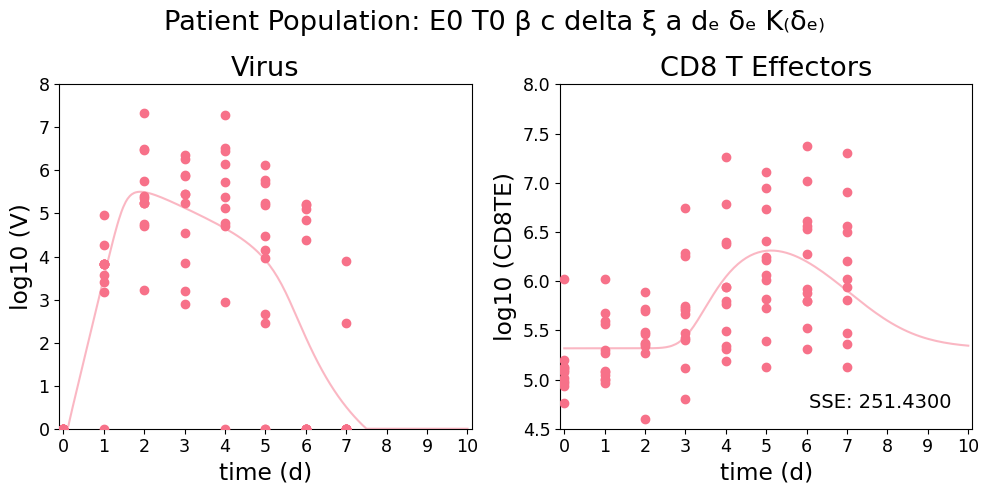

In [10]:
parameters = Parameters(
    E0=Parameter(name='E0', val=3.43E5, l_lim=2E4, u_lim=1.2E6, method='fit', space='log10'), # 1.1E5, 8.9E5 for CD38+Ki67+
    T0=Parameter(name='T0', val=4E7, l_lim=1E7, u_lim=4.001E7, method='fit', space='log10'),
    I10=Parameter(name='I10', val=75, l_lim=1, u_lim=1E3, method='fixed', space='log10'), 
    beta=Parameter(name='beta', val=1.0888E-4, l_lim=5E-7, u_lim=5E-2, method='fit', space='log10'), 
    k=Parameter(name='k', val=4.0, l_lim=1.0, u_lim=10.0, method='fixed', space='log10'), 
    p=Parameter(name='p', val=4.184819310239195, l_lim=1, u_lim=10, method='file', space='normal'), 
    c=Parameter(name='c', val=13.934, l_lim=10.0, u_lim=1E3, method='fit', space='log10'), 
    delta=Parameter(name='delta', val=0.96, l_lim=0.4, u_lim=2.5, method='fit', space='normal'),
    xi=Parameter(name='xi', val=0.1198, l_lim=1E-2, u_lim=10.0, method='fit', space='normal'), 
    a=Parameter(name='a', val=2.5, l_lim=1.0, u_lim=15, method='fit', space='normal'), 
    d_E=Parameter(name='d_E', val=0.75, l_lim=0.5, u_lim=2.5, method='fit', space='normal'),
    delta_E=Parameter(name='delta_E', val=8.939, l_lim=1E-1, u_lim=10, method='fit', space='normal'),
    K_delta_E=Parameter(name='K_delta_E', val=1.3E4, l_lim=1E1, u_lim=1E5, method='fit', space='log10'),
)

patients = Patients(ids=ids, df=df_Rahil, t_span=t_span, parameters=parameters, states=states, parameter_file='LCT.xlsx')
for target in targets:
    results = patients.optimize_parameters(method='differential_evolution', opt_target=target, 
                                        iter=100, verbose=True, path='T0IndP_CD38')

    plot(results, subplot_configuration, title=None, group=False, save=False)